In [3]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F263888%2F552038%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240909%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240909T115948Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2379eb6805a0cc4cf1d660f1bf755e75c5cc90da2946fe29aa8d47d08f4d23534ee0b92f5d16e877c7aa2a3b017f76103add4f7e1654cd7a6d1f80afe4c697f0f127eb4ed8e921693b019e5eab35de35855358a8eda56dd44f773d1dac74413aca18579e8e38c96da48bc1f38aa85b4ffd1b4b6c596dd30ad926c5102fb512e6cd7b3de4d0e809b1cdcbe8882a5ac81b0a9e3d646c84de485d789e08ec2d0cff3f189166ee4662d85a03ea9d6c8f6a6f78cbd6f885c70ec28b32c2d97d297d375c50d82fe86bab8e3c47becbfa35785af35cec77b8782554273a4bc51fb0458f738e46a620eb2939a8625116bc2b3fc640666ed627398c5402bc643b1cc894a4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117814223 bytes downloaded
Downloaded and uncompressed: credit-card
Data source import complete.


In [4]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card/previous_application.csv
/kaggle/input/credit-card/columns_description.csv
/kaggle/input/credit-card/application_data.csv


In [5]:
!pip install tensorflow scikeras imblearn xgboost

INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.4 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier , GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from joblib import Parallel, delayed
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTENC

In [ ]:

import_data = pd.read_csv('/kaggle/input/credit-card/application_data.csv')
import_data.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
list1 = list(import_data.columns)
print(len(list1))

122


In [ ]:
import_data['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


In [ ]:

na_columns = import_data.columns[import_data.isna().any()]

# Print the columns with NaN values and their respective count of NaNs
for col in na_columns:
    print(f"{col}: {import_data[col].isna().sum()} missing values")

AMT_ANNUITY: 12 missing values
AMT_GOODS_PRICE: 278 missing values
NAME_TYPE_SUITE: 1292 missing values
OWN_CAR_AGE: 202929 missing values
OCCUPATION_TYPE: 96391 missing values
CNT_FAM_MEMBERS: 2 missing values
EXT_SOURCE_1: 173378 missing values
EXT_SOURCE_2: 660 missing values
EXT_SOURCE_3: 60965 missing values
APARTMENTS_AVG: 156061 missing values
BASEMENTAREA_AVG: 179943 missing values
YEARS_BEGINEXPLUATATION_AVG: 150007 missing values
YEARS_BUILD_AVG: 204488 missing values
COMMONAREA_AVG: 214865 missing values
ELEVATORS_AVG: 163891 missing values
ENTRANCES_AVG: 154828 missing values
FLOORSMAX_AVG: 153020 missing values
FLOORSMIN_AVG: 208642 missing values
LANDAREA_AVG: 182590 missing values
LIVINGAPARTMENTS_AVG: 210199 missing values
LIVINGAREA_AVG: 154350 missing values
NONLIVINGAPARTMENTS_AVG: 213514 missing values
NONLIVINGAREA_AVG: 169682 missing values
APARTMENTS_MODE: 156061 missing values
BASEMENTAREA_MODE: 179943 missing values
YEARS_BEGINEXPLUATATION_MODE: 150007 missing 

**Fill missing values using KNN Imputer**

In [ ]:
from sklearn.impute import KNNImputer

def fill_nan_in_batches(df, batch_size=10000, n_neighbors=5):
    """Fills NaN values in a DataFrame in batches using KNNImputer.

    Args:
        df: The pandas DataFrame containing NaN values.
        batch_size: The size of each batch to process.
        n_neighbors: Number of neighbors to use for KNN imputation.

    Returns:
        The DataFrame with NaN values filled.
    """

    imputer = KNNImputer(n_neighbors=n_neighbors)
    filled_df = pd.DataFrame()

    for i in range(0, df.shape[0], batch_size):
        batch = df.iloc[i : i + batch_size]
        numerical_columns = batch.select_dtypes(include=['int64', 'float64']).columns
        filled_batch = imputer.fit_transform(batch[numerical_columns])
        filled_batch_df = pd.DataFrame(filled_batch, columns=numerical_columns)
        filled_df = pd.concat([filled_df, filled_batch_df], ignore_index=True)

    # Restore original non-numerical columns
    for col in df.columns:
        if col not in filled_df.columns:
            filled_df[col] = df[col]

    return filled_df

In [ ]:
filled_import_data = fill_nan_in_batches(import_data.copy())

In [ ]:

X = filled_import_data.drop('TARGET', axis=1)
y = filled_import_data['TARGET']

In [ ]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (307511, 121)
Shape of y: (307511,)


In [ ]:
# Count NaN values in the data
nan_X_count = X.isna().sum()
nan_y_count = y.isna().sum()

# Print the result
print("NaN count in X:", nan_X_count)
print("NaN count in y:", nan_y_count)

NaN count in X: SK_ID_CURR                  0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
AMT_CREDIT                  0
AMT_ANNUITY                 0
                        ...  
ORGANIZATION_TYPE           0
FONDKAPREMONT_MODE     210295
HOUSETYPE_MODE         154297
WALLSMATERIAL_MODE     156341
EMERGENCYSTATE_MODE    145755
Length: 121, dtype: int64
NaN count in y: 0


In [ ]:

categorical_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object']
print("Categorical feature indices:", categorical_features)

Categorical feature indices: [105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]


In [ ]:
# Initialize SMOTENC with correct categorical indices
smotenc = SMOTENC(categorical_features=categorical_features, random_state=42)

In [ ]:
print(import_data.dtypes)

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object


In [ ]:
# Apply SMOTENC
try:
    X_res, y_res = smotenc.fit_resample(X, y)
    print("SMOTENC applied successfully. Resampled data shape:", X_res.shape)
except Exception as e:
    print("Error applying SMOTENC:", str(e))

SMOTENC applied successfully. Resampled data shape: (565372, 121)


In [ ]:
# Creating a new DataFrame from the resampled data
undersampled_df = pd.DataFrame(X_res, columns=X.columns)
undersampled_df['TARGET'] = y_res


print("undersampled_df shape (rows, columns):", undersampled_df.shape)
print("Number of rows in undersampled_df:", undersampled_df.shape[0])
print("Number of columns in undersampled_df:", undersampled_df.shape[1])

# Print class distribution in the new DataFrame
print("Class distribution in undersampled_df:")
print(undersampled_df['TARGET'].value_counts())

undersampled_df shape (rows, columns): (565372, 122)
Number of rows in undersampled_df: 565372
Number of columns in undersampled_df: 122
Class distribution in undersampled_df:
TARGET
1.0    282686
0.0    282686
Name: count, dtype: int64


<ipython-input-19-11e39e6bc325>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  undersampled_df['TARGET'] = y_res


In [ ]:
num_rows = undersampled_df.shape[0]
print("Number of rows in the DataFrame:", num_rows)
print("Number of columns after SMOTE:", undersampled_df.shape[1])

Number of rows in the DataFrame: 565372
Number of columns after SMOTE: 122


In [ ]:
undersampled_df['TARGET'].value_counts()

,count
TARGET,
1.0,282686
0.0,282686


In [ ]:
# Identify categorical variables
categorical_columns = undersampled_df.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    undersampled_df[column] = le.fit_transform(undersampled_df[column])

# Check the transformed data
print(undersampled_df.head())

   SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0    100002.0           0.0          202500.0    406597.5      24700.5   
1    100003.0           0.0          270000.0   1293502.5      35698.5   
2    100004.0           0.0           67500.0    135000.0       6750.0   
3    100006.0           0.0          135000.0    312682.5      29686.5   
4    100007.0           0.0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801     -9461.0         -637.0   
1        1129500.0                    0.003541    -16765.0        -1188.0   
2         135000.0                    0.010032    -19046.0         -225.0   
3         297000.0                    0.008019    -19005.0        -3039.0   
4         513000.0                    0.028663    -19932.0        -3038.0   

   DAYS_REGISTRATION  ...  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0            -3648.0  ..

In [ ]:
# Compute the Pearson correlation matrix
correlation_matrix = undersampled_df.corr()

In [ ]:
!pip install plotly

In [ ]:
# Plot correlation matrix heatmap
# plot_correlation_matrix_heatmap(correlation_matrix)
import plotly.graph_objects as go


fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix,  # Correlation coefficients
    x=correlation_matrix.columns,  # X-axis labels
    y=correlation_matrix.columns,  # Y-axis labels
    colorscale='Viridis',
    text=correlation_matrix.applymap(lambda x: f"{x:.2f}"),  # Rounded to 2 decimal places
    hoverinfo="text+x+y",  # Show text and the axis labels on hover
    texttemplate="%{text}",  # Use text field as text in cells
))

# Increase the layout size
fig.update_layout(
    title='Correlation Matrix Heatmap with Values',
    title_x=0.5,
    width=3000,  # Increase width for better visibility
    height=3000,  # Increase height for better visibility
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis={'side': 'bottom'},
    xaxis_tickangle=-45,
    yaxis_tickangle=0,
    autosize=False,
    font=dict(size=12),
    margin=dict(t=150, l=250, r=50, b=100)
)

fig.show()

<ipython-input-25-ecd9ba0fb06f>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  text=correlation_matrix.applymap(lambda x: f"{x:.2f}"),  # Rounded to 2 decimal places


In [ ]:
# List of columns to be removed
columns_to_drop = [
    "FLAG_DOCUMENT_12",
    "FLAG_MOBIL",
    "AMT_GOODS_PRICE",
    "REG_REGION_NOT_WORK_REGION",
    "YEARS_BEGINEXPLUATATION_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BUILD_AVG",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "YEARS_BUILD_MEDI",
    "YEARS_BUILD_AVG",
    "APARTMENTS_AVG",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "LANDAREA_MEDI",
    "TOTALAREA_MODE",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "CNT_CHILDREN"
]

# Drop the columns from the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in undersampled_df.columns]
undersampled_df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Display the first few rows of the updated DataFrame to verify changes
print(undersampled_df.head())

   SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0    100002.0          202500.0    406597.5      24700.5   
1    100003.0          270000.0   1293502.5      35698.5   
2    100004.0           67500.0    135000.0       6750.0   
3    100006.0          135000.0    312682.5      29686.5   
4    100007.0          121500.0    513000.0      21865.5   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801     -9461.0         -637.0            -3648.0   
1                    0.003541    -16765.0        -1188.0            -1186.0   
2                    0.010032    -19046.0         -225.0            -4260.0   
3                    0.008019    -19005.0        -3039.0            -9833.0   
4                    0.028663    -19932.0        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0          -2120.0          4.6  ...                   3                  1   
1     

In [ ]:
len(list(undersampled_df.columns))

94

In [ ]:
correlation_matrix = undersampled_df.corr()

In [ ]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix,  # Correlation coefficients
    x=correlation_matrix.columns,  # X-axis labels
    y=correlation_matrix.columns,  # Y-axis labels
    colorscale='Viridis',
    text=correlation_matrix.applymap(lambda x: f"{x:.2f}"),  # Rounded to 2 decimal places
    hoverinfo="text+x+y",  # Show text and the axis labels on hover
    texttemplate="%{text}",  # Use text field as text in cells
))

# Increase the layout size
fig.update_layout(
    title='Correlation Matrix Heatmap with Values',
    title_x=0.5,
    width=3000,  # Increase width for better visibility
    height=3000,  # Increase height for better visibility
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis={'side': 'bottom'},
    xaxis_tickangle=-45,
    yaxis_tickangle=0,
    autosize=False,
    font=dict(size=12),  # Increase font size for visibility
    margin=dict(t=150, l=250, r=50, b=100)
)

fig.show()


<ipython-input-29-d8046e072c6a>:9: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [ ]:
# List of columns to be removed
additional_columns_to_drop = [
    "DAYS_EMPLOYED",
    "FLAG_EMP_PHONE",
    "REGION_RATING_CLIENT",
    "BASEMENTAREA_MEDI",
    "FLOORMAX_MEDI",
    "FLOORMIN_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_MODE",
    "FLOORMAX_AVG",
    "FLOORMIN_AVG",
    "NONLIVINGAREA_AVG",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "DAYS_EMPLOYED",
    "REGION_RATING_CLIENT",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "NONLIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "ELEVATORS_MEDI",
    "FLOORSMIN_AVG",
    "FLOORSMAX_AVG",
    "LIVINGAREA_MODE",
    "LIVINGAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MODE",
    "BASEMENTAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "ELEVATORS_MEDI",
    "YEARS_BUILD_MODE",
    "NONLIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAPARTMENTS_MODE",
    "FLOORSMIN_MEDI",
    "FLOORSMAX_MEDI",
    "BASEMENTAREA_MEDI",
    "LIVE_CITY_NOT_WORK_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "REGION_RATING_CLIENT",
    "REGION_RATING_CLIENT_W_CITY",
    "DAYS_EMPLOYED"
]

# Drop the columns from the DataFrame
additional_columns_to_drop = [col for col in additional_columns_to_drop if col in undersampled_df.columns]
undersampled_df.drop(columns=additional_columns_to_drop, axis=1, inplace=True)

# Display the first few rows of the updated DataFrame to verify changes
print(undersampled_df.head())


   SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0    100002.0          202500.0    406597.5      24700.5   
1    100003.0          270000.0   1293502.5      35698.5   
2    100004.0           67500.0    135000.0       6750.0   
3    100006.0          135000.0    312682.5      29686.5   
4    100007.0          121500.0    513000.0      21865.5   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0                    0.018801     -9461.0            -3648.0          -2120.0   
1                    0.003541    -16765.0            -1186.0           -291.0   
2                    0.010032    -19046.0            -4260.0          -2531.0   
3                    0.008019    -19005.0            -9833.0          -2437.0   
4                    0.028663    -19932.0            -4311.0          -3458.0   

   OWN_CAR_AGE  FLAG_WORK_PHONE  ...  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0          4.6              0.0  ...                   3                 

In [ ]:
correlation_matrix = undersampled_df.corr()

In [ ]:
import plotly.graph_objects as go

# Assuming 'correlation_matrix' is already computed
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix,  # Correlation coefficients
    x=correlation_matrix.columns,  # X-axis labels
    y=correlation_matrix.columns,  # Y-axis labels
    colorscale='Viridis',
    text=correlation_matrix.applymap(lambda x: f"{x:.2f}"),  # Rounded to 2 decimal places
    hoverinfo="text+x+y",  # Show text and the axis labels on hover
    texttemplate="%{text}",  # Use text field as text in cells
))

# Increase the layout size
fig.update_layout(
    title='Correlation Matrix Heatmap with Values',
    title_x=0.5,
    width=3000,  # Increase width for better visibility
    height=3000,  # Increase height for better visibility
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis={'side': 'bottom'},
    xaxis_tickangle=-45,
    yaxis_tickangle=0,
    autosize=False,
    font=dict(size=12),  # Increase font size for visibility
    margin=dict(t=150, l=250, r=50, b=100)
)

fig.show()


<ipython-input-32-d8046e072c6a>:9: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [ ]:
list1 = list(undersampled_df.columns)
print(list1)

['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'LANDAREA_AVG', 'COMMONAREA_MEDI', 'ENTRANCES_MEDI', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BURE

In [ ]:
undersampled_df['NAME_TYPE_SUITE'].value_counts()

,count
NAME_TYPE_SUITE,
6,498275
1,47205
5,12208
0,3418
4,1809
7,1315
3,871
2,271


In [ ]:
 len(list(undersampled_df.columns))

67

In [ ]:
import pandas as pd
import numpy as np


correlation_matrix = undersampled_df.corr()  # This computes the Pearson correlation coefficient for all pairs

# Extract correlation with the 'TARGET' column
target_correlation = correlation_matrix['TARGET']
target_correlation = np.abs(target_correlation)

print(target_correlation)

SK_ID_CURR                    0.005271
AMT_INCOME_TOTAL              0.006930
AMT_CREDIT                    0.059449
AMT_ANNUITY                   0.030517
REGION_POPULATION_RELATIVE    0.078568
                                ...   
FONDKAPREMONT_MODE            0.243917
HOUSETYPE_MODE                0.131031
WALLSMATERIAL_MODE            0.252465
EMERGENCYSTATE_MODE           0.113936
TARGET                        1.000000
Name: TARGET, Length: 67, dtype: float64


In [ ]:
# Columns to remove where correlation with 'TARGET' is exactly zero
columns_to_remove = target_correlation[target_correlation <= 1e-2].index.tolist()
print("Columns with zero correlation to TARGET:", columns_to_remove)

Columns with zero correlation to TARGET: ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT']


In [ ]:
# Drop the columns from the DataFrame
undersampled_df = undersampled_df.drop(columns=columns_to_remove)
print("Remaining columns after removal:", len(undersampled_df.columns))

Remaining columns after removal: 47


In [ ]:
!pip install scikit-learn

In [ ]:
undersampled_df.to_csv('undersampled_df.csv', index=False)

In [8]:
undersampled_df = pd.read_csv("undersampled_df.csv")

In [9]:
from sklearn.model_selection import train_test_split


X = undersampled_df.drop('TARGET', axis=1)  # Features
y = undersampled_df['TARGET']  # Target variable

In [10]:
# Drop the 'Unnamed: 0' column from the DataFrame
undersampled_df = undersampled_df.drop('Unnamed: 0', axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Printing the shapes of the splits to verify
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training features shape: (452297, 47)
Testing features shape: (113075, 47)
Training labels shape: (452297,)
Testing labels shape: (113075,)


Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [14]:
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg_model = LogisticRegression()
# Fit the model on scaled data
log_reg_model.fit(X_train_scaled, y_train)

# Predict using the scaled test set
y_pred = log_reg_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy of the model after scaling:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)


Accuracy of the model after scaling: 0.9290470926376299
Confusion Matrix:
 [[53043  3493]
 [ 4530 52009]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     56536
         1.0       0.94      0.92      0.93     56539

    accuracy                           0.93    113075
   macro avg       0.93      0.93      0.93    113075
weighted avg       0.93      0.93      0.93    113075



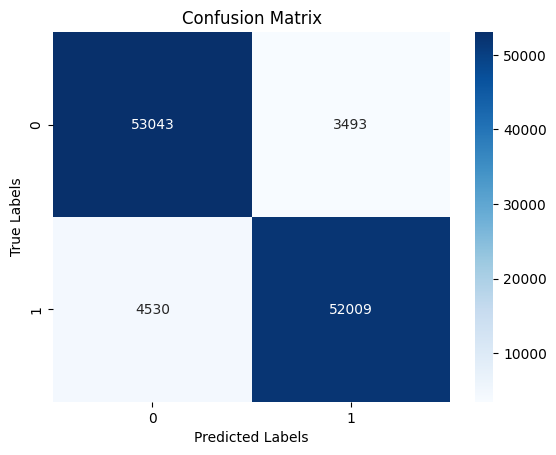

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Random Forest


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [39]:
# Initialize the Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the model
random_forest_model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = random_forest_model.predict(X_test)

# Evaluating the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy of the model:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)


Accuracy of the model: 0.832429803227946
Confusion Matrix:
 [[40249 16287]
 [ 2661 53878]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.71      0.81     56536
         1.0       0.77      0.95      0.85     56539

    accuracy                           0.83    113075
   macro avg       0.85      0.83      0.83    113075
weighted avg       0.85      0.83      0.83    113075



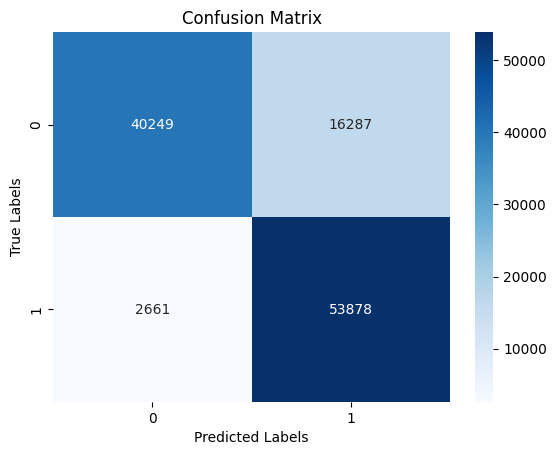

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

GBM


In [41]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting classifier
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

1# Fit the model
gbm_model.fit(X_train, y_train)

# Predicting the Test set results
y_pred_gbm = gbm_model.predict(X_test)

# Evaluating the Model
print("Accuracy:", accuracy_score(y_test, y_pred_gbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbm))
print("Classification Report:\n", classification_report(y_test, y_pred_gbm))


Accuracy: 0.7656245854521335
Confusion Matrix:
 [[31390 25146]
 [ 1356 55183]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.56      0.70     56536
         1.0       0.69      0.98      0.81     56539

    accuracy                           0.77    113075
   macro avg       0.82      0.77      0.75    113075
weighted avg       0.82      0.77      0.75    113075



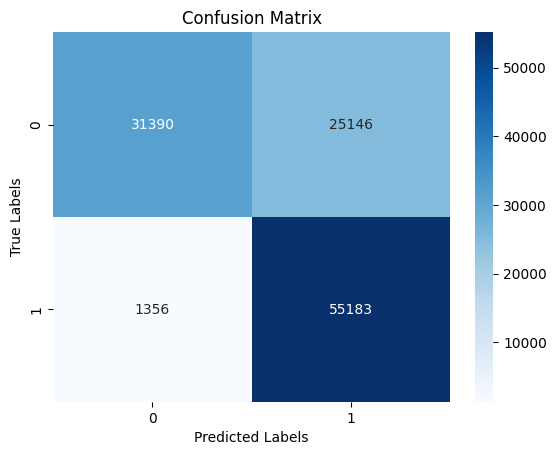

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm3 = confusion_matrix(y_test, y_pred_gbm)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

SNN


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
snn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Setup callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)

# Fit the model
history = snn_model.fit(
    X_train_scaled, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model
test_loss, test_acc = snn_model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_acc)

# Predictions for test set
y_pred_probs = snn_model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# Output the classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Epoch 1/10
36169/36184 [============================>.] - ETA: 0s - loss: 0.1995 - accuracy: 0.9291
Epoch 1: val_accuracy improved from -inf to 0.94242, saving model to best_model.keras
36184/36184 [==============================] - 62s 2ms/step - loss: 0.1995 - accuracy: 0.9291 - val_loss: 0.1670 - val_accuracy: 0.9424
Epoch 2/10
36183/36184 [============================>.] - ETA: 0s - loss: 0.1813 - accuracy: 0.9372
Epoch 2: val_accuracy did not improve from 0.94242
36184/36184 [==============================] - 63s 2ms/step - loss: 0.1813 - accuracy: 0.9371 - val_loss: 0.1682 - val_accuracy: 0.9421
Epoch 3/10
36160/36184 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9370
Epoch 3: val_accuracy improved from 0.94242 to 0.94336, saving model to best_model.keras
36184/36184 [==============================] - 62s 2ms/step - loss: 0.1812 - accuracy: 0.9370 - val_loss: 0.1667 - val_accuracy: 0.9434
Epoch 4/10
36167/36184 [============================>.] - ETA: 0s 

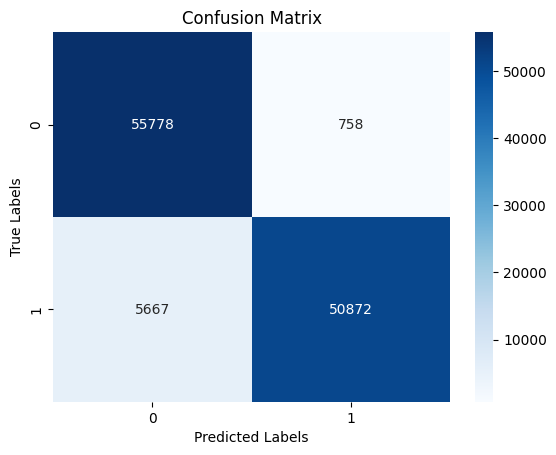

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
l1= [0.7,0.8,0.9,0.4]
l2 = [1 if i>=0.5 else 0 for i in l1]
print(l2)

[1, 1, 1, 0]


lets get training predictions and prepare them for training of meta model

In [25]:
gbm_pred = gbm_model.predict_proba(X_train)[:, 1]
gbm_pred = [1 if value >=0.5 else 0 for value in gbm_pred]
random_forest_pred = random_forest_model.predict_proba(X_train)[:, 1]
random_forest_pred = [1 if value >=0.5 else 0 for value in random_forest_pred]
log_reg_pred = log_reg_model.predict_proba(X_train)[:, 1]
log_reg_pred = [1 if value >=0.5 else 0 for value in log_reg_pred]

meta_features = np.column_stack([log_reg_pred, random_forest_pred, gbm_pred])
print(meta_features)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


[[1 1 1]
 [1 1 1]
 [1 1 1]
 ...
 [1 1 1]
 [1 0 0]
 [1 1 0]]


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

def build_simple_nn(input_dim):
    meta_model = Sequential([
        Dense(256, activation='relu', input_shape=[input_dim]),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return meta_model


In [27]:

from tensorflow.keras.optimizers import Adam
meta_model = build_simple_nn(meta_features.shape[1])
optimizer = Adam(learning_rate=0.00001)  # Lower learning rate
meta_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Setting up the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    patience=5,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity
    verbose=1              # Logs a message when stopping
)


In [29]:
print(meta_features.shape)

(452297, 3)


In [30]:
!pip install pydot graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.6 MB/s eta 0:00:00


In [31]:
# Fit the model with the early stopping callback
history = meta_model.fit(
    meta_features, y_train,
    epochs=30,              # Set the number of epochs
    batch_size=32,          # Set the batch size
    validation_split=0.2,   # Set aside 20% of the training data for validation
    callbacks=[early_stopping]  # Add the early stopping callback to the list of callbacks
)


Epoch 1/30
11308/11308 [==============================] - 29s 2ms/step - loss: 9.9277e-04 - accuracy: 0.9999 - val_loss: 6.6286e-14 - val_accuracy: 1.0000
Epoch 2/30
11308/11308 [==============================] - 27s 2ms/step - loss: 3.3159e-04 - accuracy: 1.0000 - val_loss: 1.9823e-13 - val_accuracy: 1.0000
Epoch 3/30
11308/11308 [==============================] - 26s 2ms/step - loss: 3.2011e-04 - accuracy: 1.0000 - val_loss: 2.1278e-10 - val_accuracy: 1.0000
Epoch 4/30
11308/11308 [==============================] - 26s 2ms/step - loss: 2.7148e-04 - accuracy: 1.0000 - val_loss: 8.7540e-10 - val_accuracy: 1.0000
Epoch 5/30
11308/11308 [==============================] - 26s 2ms/step - loss: 3.1090e-04 - accuracy: 1.0000 - val_loss: 2.0193e-10 - val_accuracy: 1.0000
Epoch 6/30
11308/11308 [==============================] - 26s 2ms/step - loss: 2.9861e-04 - accuracy: 1.0000 - val_loss: 1.9128e-10 - val_accuracy: 1.0000
Epoch 6: early stopping


In [32]:

log_reg_pred_test = log_reg_model.predict_proba(X_test)[:,1]

print(log_reg_pred)
rf_pred_test = random_forest_model.predict_proba(X_test)[:,1]
gbm_pred_test = gbm_model.predict_proba(X_test)[:, 1]
gbm_pred_test = [1 if value >=0.5 else 0 for value in gbm_pred_test]
rf_pred_test = [1 if value >=0.5 else 0 for value in rf_pred_test]
log_reg_pred_test = [1 if value >=0.5 else 0 for value in log_reg_pred_test]
# Stack predictions as new features for the meta-model
meta_features_test = np.column_stack([log_reg_pred_test, rf_pred_test, gbm_pred_test])
print(meta_features_test)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [33]:
dl_pred_test = meta_model.predict(meta_features_test)
dl_pred_test

3534/3534 [==============================] - 4s 1ms/step


array([[2.3339081e-14],
       [2.3339081e-14],
       [2.3339081e-14],
       ...,
       [2.3339083e-14],
       [2.3339083e-14],
       [2.3339083e-14]], dtype=float32)

In [34]:
dl_pred_test = [1 if value >= 0.5 else 0 for value in dl_pred_test]

In [35]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, dl_pred_test)
print("Classification Report:\n", classification_report(y_test, dl_pred_test))
print("Test Accuracy:", test_accuracy)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56536
         1.0       1.00      0.91      0.95     56539

    accuracy                           0.96    113075
   macro avg       0.96      0.96      0.96    113075
weighted avg       0.96      0.96      0.96    113075

Test Accuracy: 0.9560026531063454


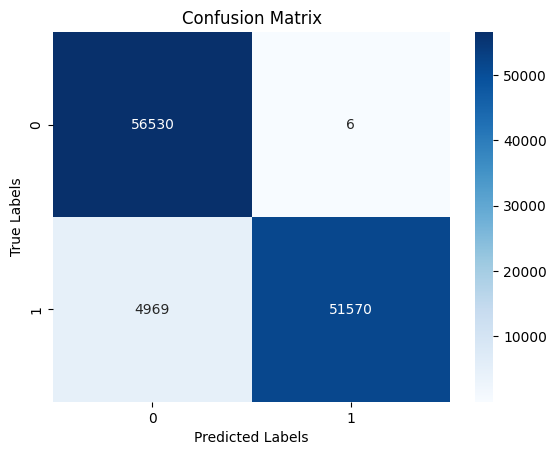

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, dl_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()